Extracting features from genre dataset...


Genres:  50%|█████     | 5/10 [05:10<05:02, 60.45s/it]C:\Users\user\AppData\Local\Temp\ipykernel_18200\1140383308.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, duration=30)
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing F:/projects/personal projects/Music-Genre-classifier/data/genre\jazz\jazz.00054.wav: 


Genres: 100%|██████████| 10/10 [09:53<00:00, 59.32s/it]


Model, scaler, and encoder saved successfully.

Classification Report:
              precision    recall  f1-score   support

       blues       0.81      0.65      0.72        20
   classical       0.90      0.95      0.93        20
     country       0.62      0.65      0.63        20
       disco       0.57      0.60      0.59        20
      hiphop       0.65      0.65      0.65        20
        jazz       0.63      0.85      0.72        20
       metal       0.86      0.95      0.90        20
         pop       0.78      0.70      0.74        20
      reggae       0.57      0.60      0.59        20
        rock       0.62      0.40      0.48        20

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200



<Figure size 1000x800 with 0 Axes>

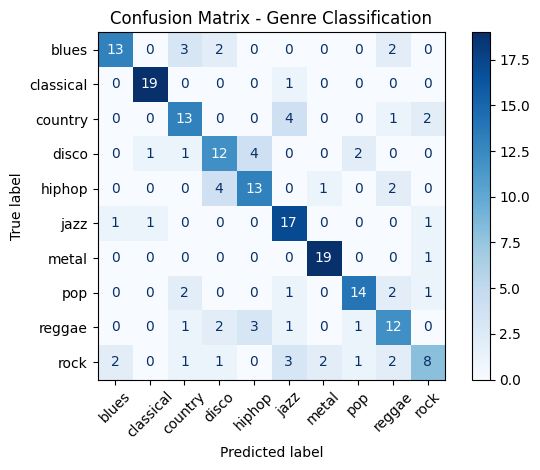

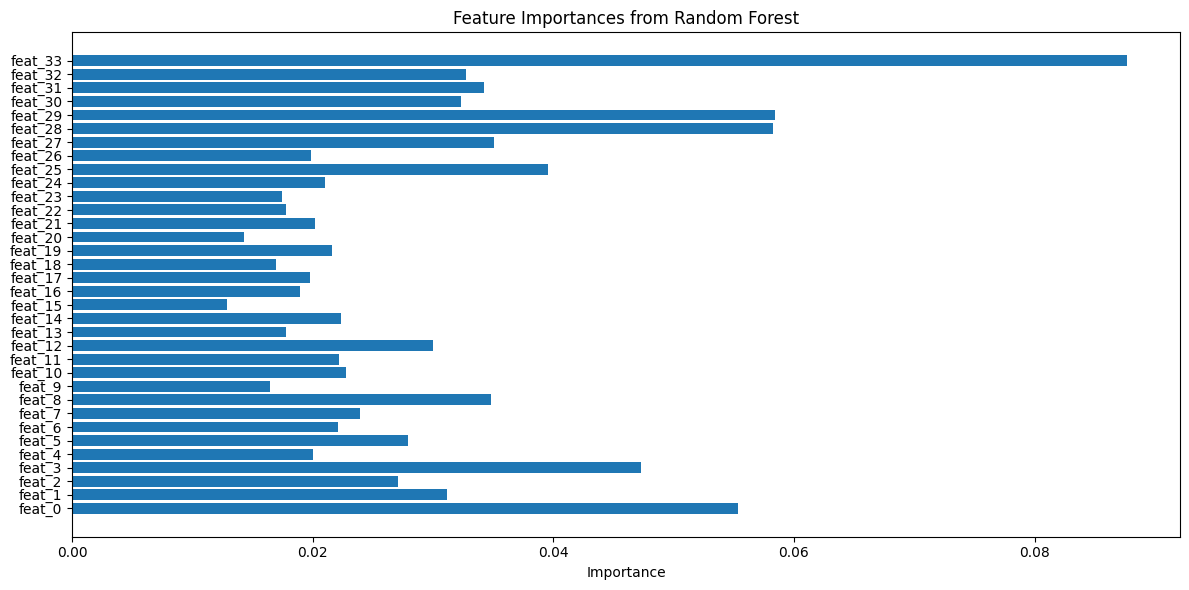

In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. Extract Features with Full Segmentation ---
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050, duration=30)
        if len(y) < sr * 5:
            return None

        segments = [y[0:sr * 10], y[sr * 10:sr * 20], y[sr * 20:sr * 30]]
        all_features = []

        for segment in segments:
            if np.sum(np.abs(segment)) < 0.01:
                continue

            mfcc = np.mean(librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13).T, axis=0)
            chroma = np.mean(librosa.feature.chroma_stft(y=segment, sr=sr).T, axis=0)
            contrast = np.mean(librosa.feature.spectral_contrast(y=segment, sr=sr).T, axis=0)
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=segment).T, axis=0).flatten()
            onset_env = librosa.onset.onset_strength(y=segment, sr=sr)
            tempo = np.mean(onset_env)

            if not (mfcc.ndim == chroma.ndim == contrast.ndim == zcr.ndim == 1):
                continue

            features = np.hstack([mfcc, chroma, contrast, zcr, [tempo]])
            all_features.append(features)

        if len(all_features) == 0:
            return None

        return np.mean(all_features, axis=0)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None



# --- 2. Load and Prepare Data ---
genres_path = "F:/projects/personal projects/Music-Genre-classifier/data/genre"
features, labels = [], []

print("Extracting features from genre dataset...")
for genre in tqdm(os.listdir(genres_path), desc="Genres"):
    genre_path = os.path.join(genres_path, genre)
    if not os.path.isdir(genre_path):
        continue
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            path = os.path.join(genre_path, file)
            data = extract_features(path)
            if data is not None:
                features.append(data)
                labels.append(genre)

features = np.array(features)
labels = np.array(labels)

# --- 3. Encode & Scale ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# --- 5. Hyperparameter Tuning with StratifiedKFold & class_weight ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = RandomForestClassifier(random_state=42, class_weight='balanced')

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Train on full training data
best_model.fit(X_train, y_train)

# --- ✅ Save model and preprocessing objects ---
import joblib

joblib.dump(best_model, "best_random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "label_encoder.pkl")

print("Model, scaler, and encoder saved successfully.")

# --- 6. Evaluation ---
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# --- 7. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Genre Classification")
plt.tight_layout()
plt.show()

# --- 8. Feature Importance Plot ---
importances = best_model.feature_importances_
feature_names = [f"feat_{i}" for i in range(X_scaled.shape[1])]

plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()


In [2]:
# --- 6. Predict Genre of Your Own Songs ---
print("\n🎧 Predicting genres of songs in 'my_songs' folder...")
my_songs_path = "F:/projects/personal projects/Music-Genre-classifier/data/my_songs"
for song in os.listdir(my_songs_path):
    if song.endswith(".wav"):
        song_path = os.path.join(my_songs_path, song)
        feat = extract_features(song_path)
        if feat is not None:
            feat_scaled = scaler.transform([feat])
            pred_index = best_model.predict(feat_scaled)[0]  # use tuned model here
            genre_name = encoder.inverse_transform([pred_index])[0]
            print(f"🎵 {song} → Predicted Genre: {genre_name}")
        else:
            print(f"⚠️ Could not extract features from {song}")



🎧 Predicting genres of songs in 'my_songs' folder...
🎵 cruelsummer.wav → Predicted Genre: hiphop
🎵 lovestory.wav → Predicted Genre: classical
🎵 wannabeslave.wav → Predicted Genre: hiphop
